In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

REPLAYS_DIR = os.path.join('../replays/')

In [2]:
dem_path = os.path.join(REPLAYS_DIR, '6227492909.jsonlines')
with open(dem_path, 'r') as fin:
    jsonlines = [json.loads(event) for event in fin.readlines()]

In [26]:
len(jsonlines)

205385

In [29]:
jsonlines[10]

{'time': -852, 'type': 'player_slot', 'key': '8', 'value': 131}

In [25]:
jsonlines[100212]

{'time': 1011,
 'type': 'DOTA_COMBATLOG_MODIFIER_REMOVE',
 'value': 0,
 'attackername': 'npc_dota_badguys_tower2_top',
 'targetname': 'npc_dota_hero_enchantress',
 'sourcename': 'dota_unknown',
 'targetsourcename': 'dota_unknown',
 'attackerhero': False,
 'targethero': True,
 'attackerillusion': False,
 'targetillusion': False,
 'inflictor': 'modifier_tower_aura_bonus'}

In [3]:
from collections import Counter

Counter([e['type'] for e in jsonlines])

Counter({'DOTA_COMBATLOG_GAME_STATE': 8,
         'player_slot': 10,
         'interval': 30580,
         'draft_start': 1,
         'draft_timings': 24,
         'actions': 113360,
         'CHAT_MESSAGE_ITEM_PURCHASE': 58,
         'DOTA_COMBATLOG_GOLD': 2612,
         'DOTA_COMBATLOG_MODIFIER_ADD': 7058,
         'DOTA_COMBATLOG_PURCHASE': 522,
         'DOTA_ABILITY_LEVEL': 406,
         'DOTA_COMBATLOG_ABILITY': 1245,
         'chatwheel': 22,
         'DOTA_COMBATLOG_ITEM': 1658,
         'chat': 10,
         'DOTA_COMBATLOG_MODIFIER_REMOVE': 7021,
         'pings': 482,
         'obs': 34,
         'DOTA_COMBATLOG_PLAYERSTATS': 225,
         'DOTA_COMBATLOG_DAMAGE': 27580,
         'DOTA_COMBATLOG_DEATH': 3260,
         'CHAT_MESSAGE_RUNE_PICKUP': 41,
         'STARTING_ITEM': 52,
         'sen': 66,
         'CHAT_MESSAGE_SENTRY_WARD_KILLED': 23,
         'DOTA_COMBATLOG_XP': 4030,
         'sen_left': 58,
         'DOTA_COMBATLOG_HEAL': 4697,
         'CHAT_MESSAGE_RUNE_BOTTLE

Damage

In [4]:
df_damage = pd.DataFrame([
    e for e in jsonlines 
    if e['type'] == 'DOTA_COMBATLOG_DAMAGE' and
    e['attackerhero'] and e['targethero']
])

display(df_damage.groupby(['attackername', 'targetname']).agg({'value': 'sum'}))
df_damage['attackername'].unique()

value
attackername                targetname                        
npc_dota_hero_bane          npc_dota_hero_enchantress     2133
                            npc_dota_hero_kunkka          3574
                            npc_dota_hero_lycan             70
                            npc_dota_hero_skywrath_mage    540
                            npc_dota_hero_tiny            2412
...                                                        ...
npc_dota_hero_winter_wyvern npc_dota_hero_kunkka          1865
                            npc_dota_hero_lycan           1971
                            npc_dota_hero_skywrath_mage   1997
                            npc_dota_hero_terrorblade      312
                            npc_dota_hero_tiny            4709

[62 rows x 1 columns]

array(['npc_dota_hero_ember_spirit', 'npc_dota_hero_kunkka',
       'npc_dota_hero_enchantress', 'npc_dota_hero_bane',
       'npc_dota_hero_tiny', 'npc_dota_hero_magnataur',
       'npc_dota_hero_lycan', 'npc_dota_hero_skywrath_mage',
       'npc_dota_hero_winter_wyvern', 'npc_dota_hero_terrorblade'],
      dtype=object)

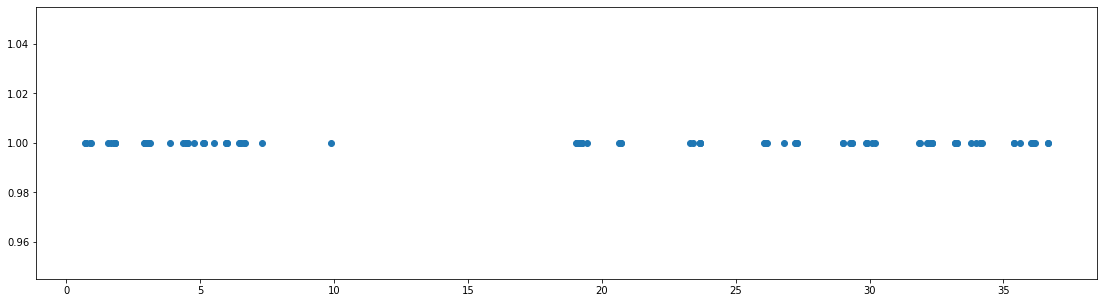

In [5]:
df_player_damage = df_damage[df_damage['attackername'] == 'npc_dota_hero_magnataur'].copy()
df_player_damage['ones'] = 1

fig, ax = plt.subplots(figsize=(19, 5))
plt.scatter(
    x=df_player_damage['time'] / 60, 
    y=df_player_damage['ones']
)

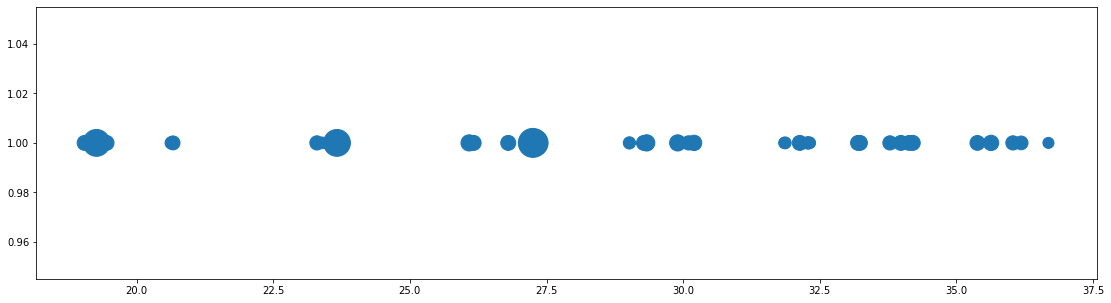

In [6]:
df_player_late_damage = df_player_damage[df_player_damage['time'] > 10 * 60].copy()

fig, ax = plt.subplots(figsize=(19, 5))
plt.scatter(
    x=df_player_late_damage['time'] / 60, 
    y=df_player_late_damage['ones'], 
    s=df_player_late_damage['value']
)

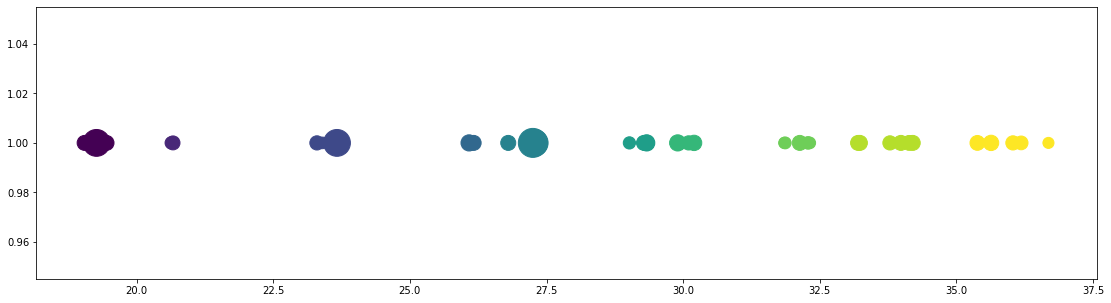

In [39]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=30, min_samples=2)
cluster = dbscan.fit_predict(df_player_late_damage[['time', 'ones']])
df_player_late_damage['cluster'] = cluster

fig, ax = plt.subplots(figsize=(19, 5))
plt.scatter(
    x=df_player_late_damage['time'] / 60, 
    y=df_player_late_damage['ones'], 
    s=df_player_late_damage['value'],
    c=df_player_late_damage['cluster']
)

In [40]:
df_player_late_damage['stime'] = df_player_late_damage['time'].apply(
    lambda t: f'{t // 60}:{str(t % 60).zfill(2)}')
df_action = df_player_late_damage.groupby('cluster').agg({'stime': ['first', 'last']})
df_action.sort_values(('stime', 'first'))

stime       
         first   last
cluster              
0        19:03  19:27
1        20:38  20:42
2        23:18  23:40
3        26:04  26:10
4        26:48  27:17
5        29:01  29:20
6        29:53  30:12
7        31:51  32:20
8        33:11  34:12
9        35:23  36:41